This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We are interesting in doing 1month vs 30month, male kidney

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

import os

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.23.5 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [2]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/liver_sex/"

# data downloaded from figshare link provided in Tabula Muris Senis paper
# URL to data is provided in the BuDDI manuscript

in_file = f"{data_path}/Liver_droplet.h5ad"
test_in_file = f"{data_path}/tabula-muris-senis-droplet-processed-official-annotations-Liver.h5ad"
results_file = f"{data_path}/liver_droplet_processed.h5ad"
de_results_file = f"{data_path}/de_pseudobulk_results.pkl"

adata = sc.read_h5ad(test_in_file)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
adata = adata.raw.to_adata()

In [4]:
adata.var

,n_cells
index,
Xkr4,147
Rp1,233
Sox17,27289
Mrpl15,95312
Lypla1,86096
...,...
LOC434960,5
LOC380994,32
LOC100041346,19


In [5]:
adata.obs

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,tissue_free_annotation,n_counts,louvain,leiden
index,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,hepatocyte,NA,nan,droplet,18-F-51,1116.0,female,Hepatocytes,Liver,Liver,2801.0,0,5
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,female,Hepatocytes,Liver,Liver,5403.0,1,1
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,female,Hepatocytes,Liver,Liver,4893.0,1,1
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,female,Hepatocytes,Liver,Liver,3692.0,1,1
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,female,Hepatocytes,Liver,Liver,4258.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X_P7_1_TTGACTTTCCGCGGTA-1,3m,10X_P7_1_TTGACTTTCCGCGGTA,hepatocyte,CL:0000182,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,3-F-57,NaN,female,nan,Liver,Liver,7569.0,1,1
10X_P7_1_TTGCCGTCAGCCAATT-1,3m,10X_P7_1_TTGCCGTCAGCCAATT,hepatocyte,CL:0000182,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,3-F-57,NaN,female,nan,Liver,Liver,5145.0,1,1
10X_P7_1_TTGGAACTCTGACCTC-1,3m,10X_P7_1_TTGGAACTCTGACCTC,hepatocyte,CL:0000182,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,3-F-57,NaN,female,nan,Liver,Liver,3534.0,6,7


## check number of cells per sample of interest

In [6]:
# how many of each mouse
adata.obs["mouse.id"].value_counts()

1-M-63     2320
30-M-3     1885
18-F-51     698
1-M-62      471
3-M-8/9     460
3-F-56      387
21-F-54     367
30-M-5      362
3-F-57      179
24-M-58      76
30-M-4       46
24-M-59      43
Name: mouse.id, dtype: int64

In [7]:
# since we are interested in sex differences, remove the mice that are 1 month old
adata = adata[np.where(adata.obs.age != "1m")]

In [8]:
# how many of each mouse
adata.obs["mouse.id"].value_counts()

30-M-3     1885
18-F-51     698
3-M-8/9     460
3-F-56      387
21-F-54     367
30-M-5      362
3-F-57      179
24-M-58      76
30-M-4       46
24-M-59      43
Name: mouse.id, dtype: int64

In [9]:
# how many of each cell
adata.obs.cell_ontology_class.value_counts()

Kupffer cell                            1932
hepatocyte                              1614
NK cell                                  305
myeloid leukocyte                        272
B cell                                   186
endothelial cell of hepatic sinusoid     155
plasmacytoid dendritic cell               26
hepatic stellate cell                     11
duct epithelial cell                       2
Name: cell_ontology_class, dtype: int64

## Preprocessing

In [10]:
# we are going to combine a few cell types
tab = adata.obs.groupby(['mouse.id', 'cell_ontology_class']).size()

tab.unstack()

cell_ontology_class,B cell,Kupffer cell,NK cell,duct epithelial cell,endothelial cell of hepatic sinusoid,hepatic stellate cell,hepatocyte,myeloid leukocyte,plasmacytoid dendritic cell
mouse.id,,,,,,,,,
3-F-56,0,12,2,0,9,1,363,0,0
3-F-57,0,1,0,0,5,0,173,0,0
3-M-8/9,0,0,0,2,5,0,453,0,0
18-F-51,24,221,109,0,27,2,267,40,8
21-F-54,39,25,32,0,14,2,250,4,1
24-M-58,0,0,0,0,2,0,74,0,0
24-M-59,3,18,7,0,5,1,4,5,0
30-M-3,33,1608,56,0,3,0,1,177,7
30-M-4,14,3,11,0,5,0,0,12,1


In [11]:
# merge them
cell_dict = {'hepatic_stellate': ["hepatic stellate cell"],
             'hepatic_sinusoid': ["endothelial cell of hepatic sinusoid", "duct epithelial cell"],
             'b_cell': ["B cell"],
             'kupffer': ["Kupffer cell"],
             'NK': ["NK cell"], 
             'hepatocyte': ["hepatocyte"], 
             'myeloid_leukocyte': ["myeloid leukocyte"], 
             'plasmacytoid_dendritic_cell': ["plasmacytoid dendritic cell"]}


# Initialize empty column in cell metadata
adata.obs['names_merged'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.cell_ontology_class).isin(cell_dict[i])
    adata.obs.loc[ind,'names_merged'] = i

adata.obs.names_merged.value_counts()

<ipython-input-11-73b46a7288df>:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['names_merged'] = np.nan


kupffer                        1932
hepatocyte                     1614
NK                              305
myeloid_leukocyte               272
b_cell                          186
hepatic_sinusoid                157
plasmacytoid_dendritic_cell      26
hepatic_stellate                 11
Name: names_merged, dtype: int64

In [12]:
# we are going to only keep some samples
# ones that have enough cells per cell type
tab = adata.obs.groupby(['mouse.id', 'names_merged']).size()

tab.unstack()

names_merged,NK,b_cell,hepatic_sinusoid,hepatic_stellate,hepatocyte,kupffer,myeloid_leukocyte,plasmacytoid_dendritic_cell
mouse.id,,,,,,,,
3-F-56,2,0,9,1,363,12,0,0
3-F-57,0,0,5,0,173,1,0,0
3-M-8/9,0,0,7,0,453,0,0,0
18-F-51,109,24,27,2,267,221,40,8
21-F-54,32,39,14,2,250,25,4,1
24-M-58,0,0,2,0,74,0,0,0
24-M-59,7,3,5,1,4,18,5,0
30-M-3,56,33,3,0,1,1608,177,7
30-M-4,11,14,5,0,0,3,12,1


In [13]:
# check we removed everything
tab = adata.obs.groupby(['mouse.id', 'names_merged']).size()

tab.unstack()

names_merged,NK,b_cell,hepatic_sinusoid,hepatic_stellate,hepatocyte,kupffer,myeloid_leukocyte,plasmacytoid_dendritic_cell
mouse.id,,,,,,,,
3-F-56,2,0,9,1,363,12,0,0
3-F-57,0,0,5,0,173,1,0,0
3-M-8/9,0,0,7,0,453,0,0,0
18-F-51,109,24,27,2,267,221,40,8
21-F-54,32,39,14,2,250,25,4,1
24-M-58,0,0,2,0,74,0,0,0
24-M-59,7,3,5,1,4,18,5,0
30-M-3,56,33,3,0,1,1608,177,7
30-M-4,11,14,5,0,0,3,12,1


normalizing counts per cell
    finished (0:00:00)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


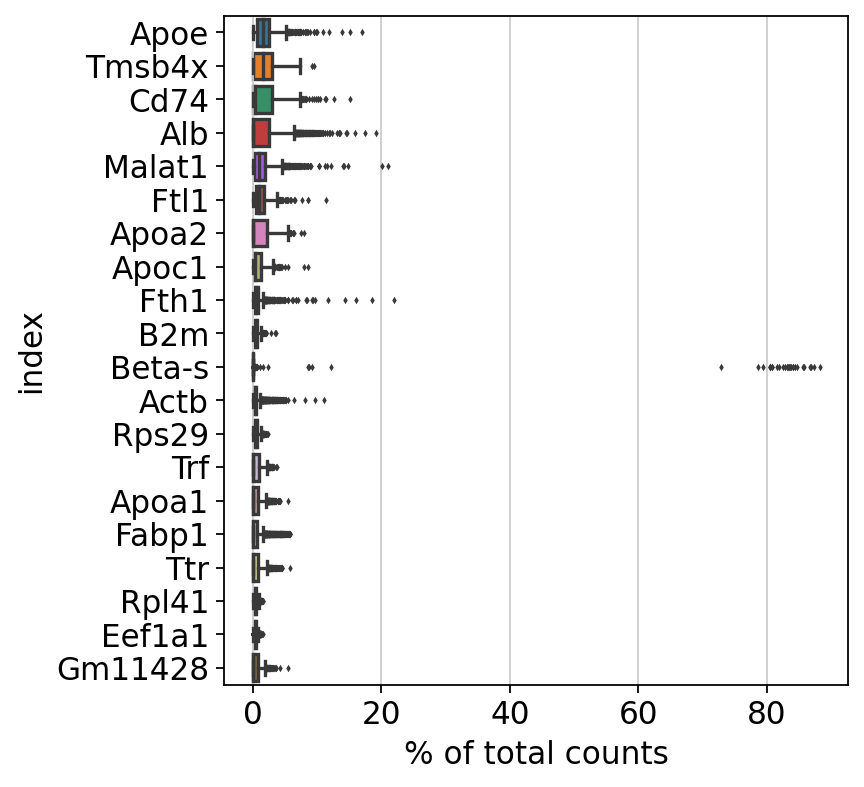

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [15]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 4509 genes that are detected in less than 3 cells


In [16]:
adata.var_names[np.where(adata.var_names.str.startswith('MT'))]

Index([], dtype='object', name='index')

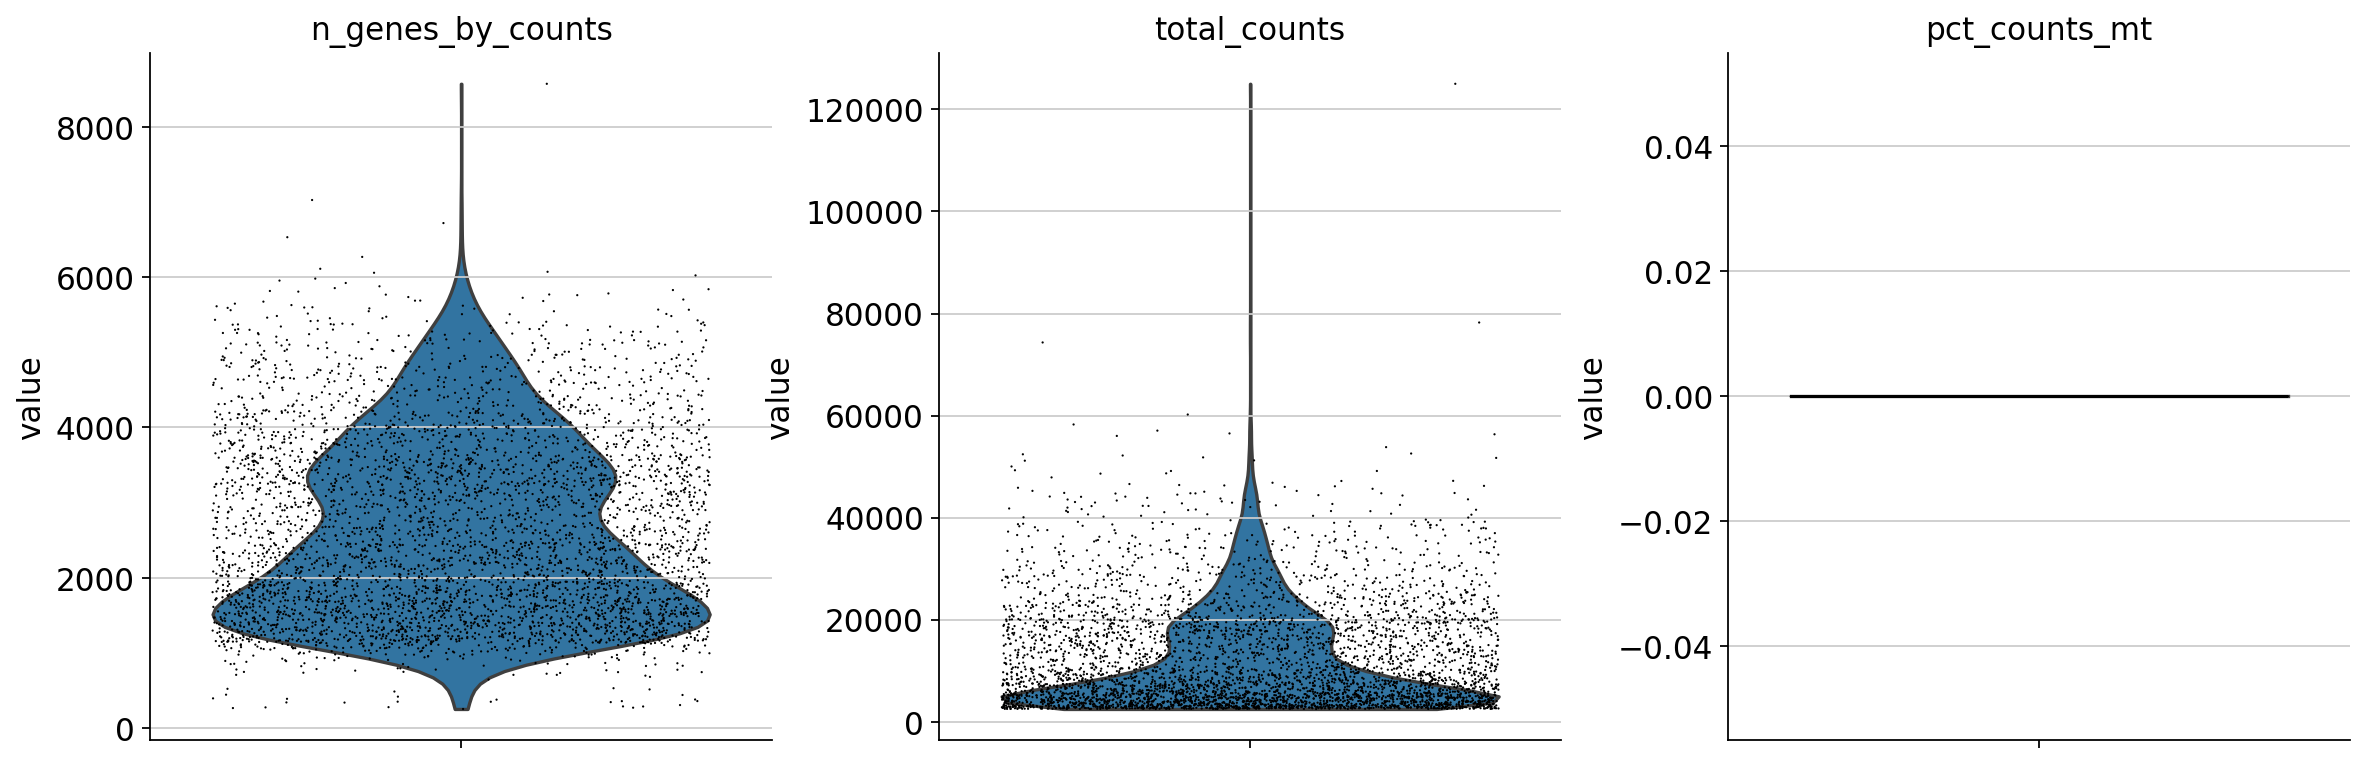

In [17]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

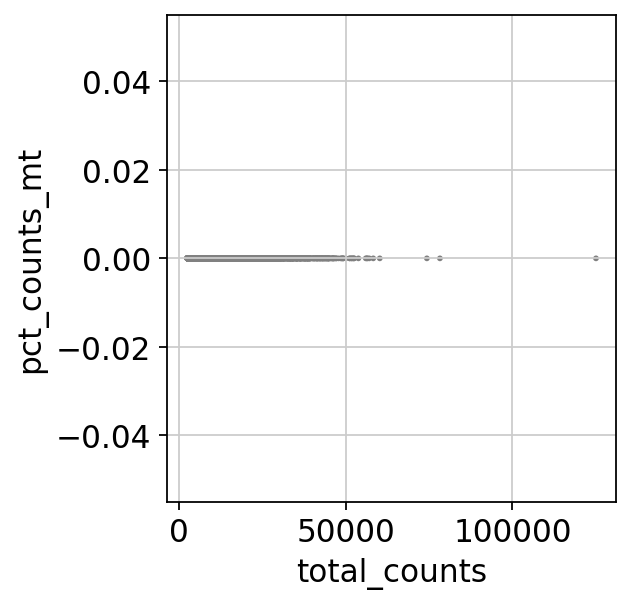

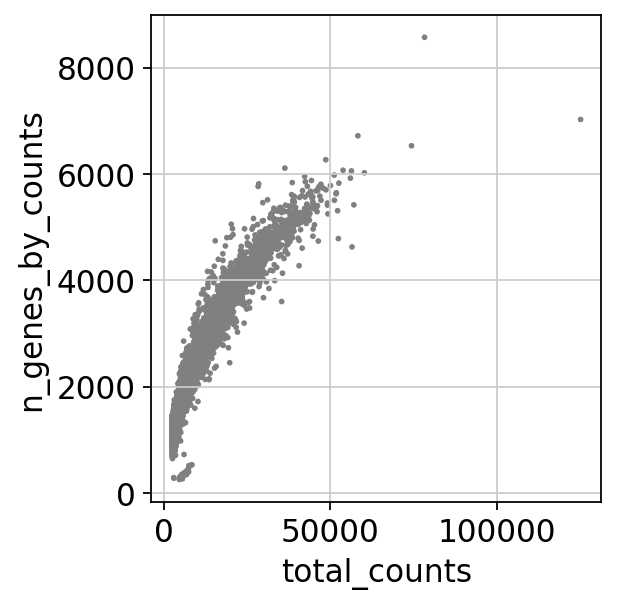

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [19]:
# slice the data based on the plots from above
# remove cells with more than 9000 genes
# remove cells with more than 5% MTgenes
# we aren't removing anything
adata = adata[adata.obs.n_genes_by_counts < 9000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Make pseudobulks

In [20]:
adata.obs["mouse.id"].unique()

['18-F-51', '21-F-54', '24-M-58', '24-M-59', '30-M-3', '30-M-4', '30-M-5', '3-M-8/9', '3-F-56', '3-F-57']
Categories (10, object): ['3-F-56', '3-F-57', '3-M-8/9', '18-F-51', ..., '24-M-59', '30-M-3', '30-M-4', '30-M-5']

In [21]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'sc_preprocessing.sc_preprocess' from '/beevol/home/davidson/checkouts/sc_bulk_ood/sc_preprocessing/0_qc_notebooks/../../sc_preprocessing/sc_preprocess.py'>

In [22]:
# make columns that sc_preprocessing expects
adata.var["gene_ids"] = adata.var.index
adata.obs["scpred_CellType"] = adata.obs["names_merged"]


# metadata
sample_order = adata.obs["mouse.id"].unique()


# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "sex", "age", "cell_type"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, len(adata.var.gene_ids)) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 30
idx = 0

# how many samples
num_samp = 10

# make empty objects
prop_df_all = None
pseudobulks_df_all = None

for curr_samp in sample_order:


  subset_idx = np.where(adata.obs["mouse.id"] == curr_samp)
  temp_adata = adata[subset_idx]

  curr_sex = temp_adata.obs.sex.unique()[0]
  curr_age = temp_adata.obs.age.unique()[0]

  print(f"running {curr_samp} {curr_sex} {curr_age}")

  # get the single cell type proportions
  print("get_single_celltype_prop_matrix")
  ct_prop_df = sc_preprocess.get_only1_celltype_prop_matrix(num_samp=num_samp,
                                                              cell_order=cell_order)

  # now get the cell-type specific pseudobulks
  print("use_prop_make_sum")
  prop_df, pseudobulks_df, _ = sc_preprocess.use_prop_make_sum(temp_adata,  
                                                                      num_cells=num_cells, 
                                                                      props_vec=ct_prop_df, 
                                                                      cell_noise=cell_noise,
                                                                      sample_noise=None,
                                                                      useSampleNoise=False)

  # make the proportions instead of cell counts
  prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

  # make metadata
  curr_meta_df = pd.DataFrame([curr_samp]*(num_samp*len(cell_order)), columns=["sample_id"])
  curr_meta_df["sex"] = [curr_sex]*(num_samp*len(cell_order)) 
  curr_meta_df["age"] = [curr_age]*(num_samp*len(cell_order)) 
  curr_cell_type = np.repeat(cell_order, num_samp)
  curr_meta_df["cell_type"] = curr_cell_type

  total_meta_df = pd.concat([total_meta_df, curr_meta_df])


  # put proportions and pseudobulks together
  print("concat")      
  if prop_df is None: 
    prop_df_all = prop_df
    pseudobulks_df_all = pseudobulks_df
  else:
    prop_df_all = pd.concat([prop_df_all, prop_df])
    pseudobulks_df_all = pd.concat([pseudobulks_df_all, pseudobulks_df])

         





<ipython-input-22-1d35ae482dcf>:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_ids"] = adata.var.index


running 18-F-51 female 18m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 21-F-54 female 21m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 24-M-58 male 24m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 24-M-59 male 24m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 30-M-3 male 30m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 30-M-4 male 30m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 30-M-5 male 30m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 3-M-8/9 male 3m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 3-F-56 female 3m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat
running 3-F-57 female 3m
get_single_celltype_prop_matrix
use_prop_make_sum
0
concat


In [23]:
prop_df_all

,hepatocyte,hepatic_sinusoid,kupffer,hepatic_stellate,NK,plasmacytoid_dendritic_cell,b_cell,myeloid_leukocyte
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
pseudobulks_df_all

gene_ids,Sox17,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Sntg1,Rrs1,Adhfe1,...,Tmlhe,Zf12,Kdm5d,Eif2s3y,Uty,Ddx3y,Usp9y,LOC380994,LOC100041346,Erdr1
0,0.0,19.0,28.0,3.0,6.0,2.0,10.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
0,0.0,21.0,27.0,7.0,9.0,3.0,19.0,0.0,8.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
0,0.0,20.0,34.0,6.0,6.0,3.0,12.0,0.0,5.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
0,0.0,13.0,29.0,3.0,5.0,3.0,16.0,0.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
0,0.0,7.0,26.0,5.0,10.0,2.0,17.0,0.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
total_meta_df

,sample_id,sex,age,cell_type
0,18-F-51,female,18m,hepatocyte
1,18-F-51,female,18m,hepatocyte
2,18-F-51,female,18m,hepatocyte
3,18-F-51,female,18m,hepatocyte
4,18-F-51,female,18m,hepatocyte
...,...,...,...,...
75,3-F-57,female,3m,myeloid_leukocyte
76,3-F-57,female,3m,myeloid_leukocyte
77,3-F-57,female,3m,myeloid_leukocyte
78,3-F-57,female,3m,myeloid_leukocyte


# DESeq

In [26]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [27]:
def get_cell_type_DE(adata, meta_DESeq, expr_matr, cell_type_interest):

    # make it conform to DESeq reqr
    expr_matr = np.ceil(expr_matr)
    expr_matr = expr_matr+1

    # only compare with samples that have enough observations
    keep_samp_ids = adata.obs.groupby(['names_merged', 'mouse.id']).size()
    keep_samp_ids = keep_samp_ids[np.where(keep_samp_ids[cell_type_interest] > 20)[0]].unstack().columns.to_list()

    # if not enough cells, ignore
    if len(keep_samp_ids) == 0:
        return (None, None)
    
    samp_idx = np.where(np.isin(meta_DESeq.sample_id, keep_samp_ids))[0]
    expr_matr = expr_matr.iloc[samp_idx,]
    meta_DESeq = meta_DESeq.iloc[samp_idx,]
    
    # get the index of the cell type of interest
    cell_idx = np.where(meta_DESeq.cell_type == cell_type_interest)[0]
    de_cell = expr_matr.iloc[cell_idx,]
    meta_DESeq_cell = meta_DESeq.iloc[cell_idx,]

    # reindex so that anndata obj can be created easily
    new_index = ["samp_" + str(s) for s in range(len(cell_idx))]
    de_cell.index = new_index
    meta_DESeq_cell.index = new_index

    # filter out lowly expressed genes
    genes_to_keep = de_cell.columns[de_cell.mean(axis=0) > 1]
    de_cell = de_cell[genes_to_keep]    
    print(de_cell.shape)        

    # run deseq
    dds_cell = DeseqDataSet(
        counts=de_cell,
        clinical=meta_DESeq_cell,
        design_factors=["sex"],
        refit_cooks=True
    )

    print("running contrast")

    dds_cell.deseq2()
    cell_res = DeseqStats(dds_cell, contrast=["sex", "female", "male"])
    cell_res.summary()

    # get the DESeq res matrix
    cell_res_df = cell_res.results_df

    # get the genes of interest
    cell_res_df_sig = cell_res_df.iloc[np.where(cell_res_df["padj"] < 0.01)[0]]
    cell_res_df_sig = cell_res_df_sig.iloc[np.argsort(np.abs(cell_res_df_sig["log2FoldChange"]))]
    top_genes = cell_res_df_sig.index.to_list()

    return (top_genes, cell_res_df) 

In [28]:
_, cell_res_df = get_cell_type_DE(adata, total_meta_df, pseudobulks_df_all, "kupffer")


(40, 14208)
running contrast
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.51 seconds.

Fitting dispersion trend curve...
... done in 5.08 seconds.

Fitting MAP dispersions...
... done in 2.30 seconds.

Fitting LFCs...
... done in 1.61 seconds.

Refitting 7 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 1.17 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Sox17,1.999591,-1.163764,0.415361,-2.801812,5.081641e-03,1.397590e-02
Mrpl15,14.786774,-0.630352,0.147491,-4.273826,1.921468e-05,1.068854e-04
Lypla1,9.670205,0.029429,0.186019,0.158204,8.742957e-01,9.134378e-01
Tcea1,22.101344,-0.741318,0.123105,-6.021827,1.724589e-09,2.161297e-08
Atp6v1h,14.990228,-0.398588,0.143718,-2.773406,5.547291e-03,1.506516e-02
...,...,...,...,...,...,...
Eif2s3y,4.448679,-2.603826,0.352570,-7.385269,1.521459e-13,3.971294e-12
Uty,2.366094,-1.352881,0.392543,-3.446449,5.680068e-04,2.107988e-03
Ddx3y,10.736885,-3.987510,0.352987,-11.296473,1.365949e-29,3.648828e-27


In [29]:
cell_type_interest = "kupffer"

# only compare with samples that have enough observations
keep_samp_ids = adata.obs.groupby(['names_merged', 'mouse.id']).size()
keep_samp_ids = keep_samp_ids[np.where(keep_samp_ids[cell_type_interest] > 20)[0]].unstack().columns.to_list()

samp_idx = np.where(np.isin(total_meta_df.sample_id, keep_samp_ids))[0]
pseudobulks_samps = pseudobulks_df_all.iloc[samp_idx,]
meta_DESeq_samps = total_meta_df.iloc[samp_idx,]

# get the index of the cell type of interest
cell_idx = np.where(meta_DESeq_samps.cell_type == cell_type_interest)[0]
de_cell = pseudobulks_samps.iloc[cell_idx,]
meta_DESeq_cell = meta_DESeq_samps.iloc[cell_idx,]


In [30]:
de_cell["Mup7"]

0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
Name: Mup7, dtype: float64

In [31]:
meta_DESeq_cell

,sample_id,sex,age,cell_type
20,18-F-51,female,18m,kupffer
21,18-F-51,female,18m,kupffer
22,18-F-51,female,18m,kupffer
23,18-F-51,female,18m,kupffer
24,18-F-51,female,18m,kupffer
25,18-F-51,female,18m,kupffer
26,18-F-51,female,18m,kupffer
27,18-F-51,female,18m,kupffer
28,18-F-51,female,18m,kupffer
29,18-F-51,female,18m,kupffer


In [32]:
cell_res_df.loc["A1bg"]

baseMean          3.877263e+01
log2FoldChange    6.633534e+00
lfcSE             4.913917e-01
stat              1.349948e+01
pvalue            1.574764e-41
padj              8.986892e-39
Name: A1bg, dtype: float64

In [33]:
cell_res_df_sig = cell_res_df.iloc[np.where(cell_res_df["padj"] < 0.0000001)[0]]
cell_res_df_sig = cell_res_df_sig.iloc[np.argsort(np.abs(cell_res_df_sig["padj"]))]

In [34]:
cell_res_df_sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Xist,87.332374,6.697904,0.254313,26.337236,7.187248e-153,9.023590e-149
H2-K1,591.441037,-0.752358,0.039052,-19.265484,1.046828e-82,6.571461e-79
Atp5l,237.925412,-0.813920,0.048546,-16.765903,4.333811e-63,1.813700e-59
Pabpc1,183.706549,-1.007632,0.062806,-16.043520,6.345368e-58,1.991652e-54
Hspa5,155.009009,-1.090873,0.071424,-15.273262,1.152600e-52,2.894179e-49
...,...,...,...,...,...,...
Tmed5,22.734523,-0.885117,0.153784,-5.755594,8.633748e-09,9.483527e-08
Trex1,22.768943,-0.855736,0.148734,-5.753473,8.742848e-09,9.586590e-08
Setd8,10.385023,-1.006196,0.174881,-5.753592,8.736703e-09,9.586590e-08


In [35]:
np.where(cell_res_df_sig.index == "Cyp4a12a")

(array([], dtype=int64),)

In [36]:

all_res_df = {}
for curr_cell_type in adata.obs.scpred_CellType.unique():

    print(curr_cell_type)
    top_genes, _ = get_cell_type_DE(adata, total_meta_df, pseudobulks_df_all, curr_cell_type)
    all_res_df[curr_cell_type] = top_genes
    

hepatocyte
(70, 13014)
running contrast
Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 2.71 seconds.

Fitting dispersion trend curve...
... done in 4.54 seconds.

Fitting MAP dispersions...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])


... done in 2.91 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 1.65 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.12 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Mrpl15,27.166375,-0.187237,0.148683,-1.259304,2.079204e-01,3.389302e-01
Lypla1,53.136199,-0.140386,0.093602,-1.499818,1.336616e-01,2.429910e-01
Tcea1,17.103654,-0.703048,0.146103,-4.811994,1.494320e-06,1.588980e-05
Atp6v1h,8.753472,0.148205,0.159648,0.928325,3.532389e-01,5.010141e-01
Rb1cc1,7.972677,0.148407,0.141937,1.045581,2.957545e-01,4.415834e-01
...,...,...,...,...,...,...
Eif2s3y,5.756754,-3.729256,0.271036,-13.759250,4.481493e-43,1.970961e-40
Uty,1.791855,-1.671797,0.282857,-5.910392,3.412947e-09,7.120559e-08
Ddx3y,7.922110,-4.253000,0.249298,-17.059874,2.951901e-65,2.163743e-62


hepatic_sinusoid
(20, 12523)
running contrast
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.82 seconds.

Fitting dispersion trend curve...
... done in 4.28 seconds.

Fitting MAP dispersions...
... done in 1.75 seconds.

Fitting LFCs...
... done in 0.79 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.78 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Sox17,10.038152,0.289170,0.233830,1.236667,2.162108e-01,3.010970e-01
Mrpl15,9.656655,-0.500421,0.244455,-2.047087,4.064956e-02,7.381384e-02
Lypla1,11.315527,-0.178999,0.210654,-0.849730,3.954755e-01,4.935701e-01
Tcea1,21.471895,0.027387,0.158826,0.172432,8.630979e-01,8.903504e-01
Atp6v1h,9.932634,-0.082814,0.220872,-0.374940,7.077054e-01,7.753532e-01
...,...,...,...,...,...,...
Kdm5d,2.418493,-1.596383,0.519973,-3.070128,2.139668e-03,5.711917e-03
Eif2s3y,6.723827,-3.336806,0.481673,-6.927534,4.282409e-12,5.941968e-11
Uty,2.196772,-1.392579,0.526061,-2.647181,8.116582e-03,1.827199e-02


kupffer
(40, 14208)
running contrast
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.39 seconds.

Fitting dispersion trend curve...
... done in 5.01 seconds.

Fitting MAP dispersions...
... done in 2.32 seconds.

Fitting LFCs...
... done in 1.69 seconds.

Refitting 7 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 1.13 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Sox17,1.999591,-1.163764,0.415361,-2.801812,5.081641e-03,1.397590e-02
Mrpl15,14.786774,-0.630352,0.147491,-4.273826,1.921468e-05,1.068854e-04
Lypla1,9.670205,0.029429,0.186019,0.158204,8.742957e-01,9.134378e-01
Tcea1,22.101344,-0.741318,0.123105,-6.021827,1.724589e-09,2.161297e-08
Atp6v1h,14.990228,-0.398588,0.143718,-2.773406,5.547291e-03,1.506516e-02
...,...,...,...,...,...,...
Eif2s3y,4.448679,-2.603826,0.352570,-7.385269,1.521459e-13,3.971294e-12
Uty,2.366094,-1.352881,0.392543,-3.446449,5.680068e-04,2.107988e-03
Ddx3y,10.736885,-3.987510,0.352987,-11.296473,1.365949e-29,3.648828e-27


hepatic_stellate
NK
(40, 12522)
running contrast
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.40 seconds.

Fitting dispersion trend curve...
... done in 4.43 seconds.

Fitting MAP dispersions...
... done in 2.06 seconds.

Fitting LFCs...
... done in 0.91 seconds.

Refitting 7 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 1.18 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Sox17,1.180864,-0.118902,0.440586,-0.269873,7.872581e-01,NaN
Mrpl15,13.441262,-0.582926,0.169835,-3.432304,5.984757e-04,3.107823e-03
Lypla1,10.785562,-0.078397,0.182150,-0.430395,6.669086e-01,7.628459e-01
Tcea1,20.276565,-0.442777,0.129543,-3.418004,6.308214e-04,3.249285e-03
Atp6v1h,5.171506,-0.490478,0.235855,-2.079574,3.756458e-02,8.858661e-02
...,...,...,...,...,...,...
Kdm5d,1.990531,-1.326219,0.382902,-3.463601,5.329957e-04,2.823338e-03
Eif2s3y,9.408420,-3.971915,0.337888,-11.755107,6.647610e-32,7.993382e-29
Uty,1.409882,-0.587210,0.417037,-1.408051,1.591160e-01,2.683424e-01


plasmacytoid_dendritic_cell
b_cell
(40, 13626)
running contrast
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.26 seconds.

Fitting dispersion trend curve...
... done in 4.79 seconds.

Fitting MAP dispersions...
... done in 2.17 seconds.

Fitting LFCs...
... done in 1.53 seconds.

Refitting 14 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 1.22 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Mrpl15,13.961488,-0.324748,0.197790,-1.641879,1.006150e-01,1.856556e-01
Lypla1,10.668963,0.269326,0.192380,1.399967,1.615231e-01,2.707818e-01
Tcea1,17.229123,0.051884,0.171956,0.301729,7.628590e-01,8.424111e-01
Atp6v1h,4.507392,-0.140525,0.233444,-0.601962,5.471995e-01,6.724514e-01
Rb1cc1,8.319530,-0.311788,0.189204,-1.647893,9.937462e-02,1.838033e-01
...,...,...,...,...,...,...
Kdm5d,1.708688,-0.701823,0.404712,-1.734130,8.289507e-02,1.586193e-01
Eif2s3y,6.942078,-3.516305,0.357926,-9.824104,8.865902e-23,3.896993e-20
Uty,1.270403,-0.154027,0.415101,-0.371059,7.105938e-01,8.016712e-01


myeloid_leukocyte
(30, 12481)
running contrast
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.70 seconds.

Fitting dispersion trend curve...
... done in 4.36 seconds.

Fitting MAP dispersions...
... done in 2.05 seconds.

Fitting LFCs...
... done in 0.92 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.80 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Sox17,1.238129,0.873411,0.503539,1.734544,8.282154e-02,NaN
Mrpl15,20.252650,-0.451746,0.157949,-2.860078,4.235362e-03,1.694292e-02
Lypla1,10.029694,-0.505126,0.228661,-2.209058,2.717059e-02,7.296850e-02
Tcea1,27.821087,-0.040116,0.140160,-0.286215,7.747135e-01,8.388056e-01
Atp6v1h,11.012797,-0.063432,0.239636,-0.264702,7.912389e-01,8.518132e-01
...,...,...,...,...,...,...
Uty,1.759039,-0.937829,0.520159,-1.802964,7.139383e-02,1.524931e-01
Ddx3y,16.266675,-4.446681,0.467610,-9.509383,1.917974e-21,2.831963e-19
LOC380994,1.529151,-0.720576,0.533965,-1.349483,1.771819e-01,2.985085e-01


In [37]:
np.where(np.isin(all_res_df["kupffer"], "Cyp4a12a" ))

(array([], dtype=int64),)

In [38]:
de_results_file

'/beevol/home/davidson/checkouts/sc_bulk_ood/sc_preprocessing/0_qc_notebooks/../../data/single_cell_data/liver_sex//de_pseudobulk_results.pkl'

In [39]:
import pickle

print("write")        

pickle.dump( all_res_df, open( de_results_file, "wb" ) )



write


In [40]:
temp_file = '/beevol/home/davidson/checkouts/sc_bulk_ood/sc_preprocessing/0_qc_notebooks/../../data/single_cell_data/liver_sex//hepatocytes_pseudobulk_results.pkl'
_, cell_res_df = get_cell_type_DE(adata, total_meta_df, pseudobulks_df_all, "hepatocyte")
pickle.dump( cell_res_df, open( temp_file, "wb" ) )


(70, 13014)
running contrast
Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 2.61 seconds.

Fitting dispersion trend curve...
... done in 4.58 seconds.

Fitting MAP dispersions...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])


... done in 2.80 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 1.52 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.21 seconds.

Log2 fold change & Wald test p-value: sex female vs male


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Mrpl15,27.166375,-0.187237,0.148683,-1.259304,2.079204e-01,3.389302e-01
Lypla1,53.136199,-0.140386,0.093602,-1.499818,1.336616e-01,2.429910e-01
Tcea1,17.103654,-0.703048,0.146103,-4.811994,1.494320e-06,1.588980e-05
Atp6v1h,8.753472,0.148205,0.159648,0.928325,3.532389e-01,5.010141e-01
Rb1cc1,7.972677,0.148407,0.141937,1.045581,2.957545e-01,4.415834e-01
...,...,...,...,...,...,...
Eif2s3y,5.756754,-3.729256,0.271036,-13.759250,4.481493e-43,1.970961e-40
Uty,1.791855,-1.671797,0.282857,-5.910392,3.412947e-09,7.120559e-08
Ddx3y,7.922110,-4.253000,0.249298,-17.059874,2.951901e-65,2.163743e-62


In [41]:
cell_res_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Mrpl15,27.166375,-0.187237,0.148683,-1.259304,2.079204e-01,3.389302e-01
Lypla1,53.136199,-0.140386,0.093602,-1.499818,1.336616e-01,2.429910e-01
Tcea1,17.103654,-0.703048,0.146103,-4.811994,1.494320e-06,1.588980e-05
Atp6v1h,8.753472,0.148205,0.159648,0.928325,3.532389e-01,5.010141e-01
Rb1cc1,7.972677,0.148407,0.141937,1.045581,2.957545e-01,4.415834e-01
...,...,...,...,...,...,...
Eif2s3y,5.756754,-3.729256,0.271036,-13.759250,4.481493e-43,1.970961e-40
Uty,1.791855,-1.671797,0.282857,-5.910392,3.412947e-09,7.120559e-08
Ddx3y,7.922110,-4.253000,0.249298,-17.059874,2.951901e-65,2.163743e-62
